In [1]:
import torch
from torch import nn
import pandas as pd
from torch import optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm
import math
from hilbertcurve.hilbertcurve import HilbertCurve
from math import sqrt
from torchvision import datasets, transforms
import os 

In [2]:
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 200
PATIANCE = 10
LEARNING_RATE = 1e-3
NUM_CLASSES = 10
PATCH_SIZE = 4
IMAGE_SIZE = 32
IN_CHANNELS = 3
NUM_HEADS = 8
DROPOUT = 0.001
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION = "gelu"
NUM_ENCODERS = 4
EMBEDING_DIMENTION = (PATCH_SIZE**2) * IN_CHANNELS
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

print(NUM_PATCHES)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Cuda Specific 
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Apple Metal Specific 
torch.mps.manual_seed(RANDOM_SEED)

64


In [3]:
if torch.backends.mps.is_available(): 
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

mps


In [4]:
def HilbertIndices(n):
    """
    Generate Hilbert indices for a grid approximating a square layout of patches.

    Args:
    n (int): Total number of patches.

    Returns:
    np.array: Indices sorted according to Hilbert curve distances.
    """
    # Determine the order of the Hilbert curve based on the number of patches
    order = int(np.ceil(np.log2(np.sqrt(n))))
    print("Order is ", order)

    # Initialize Hilbert curve with 2 dimensions and determined order
    hilbert_curve = HilbertCurve(p=order, n=2)
    points = []

    # Determine the maximum x and y values based on the number of patches
    side_length = int(np.ceil(np.sqrt(n)))

    # Collect all points whose Hilbert distances need to be calculated
    for i in range(n):
        x = i // side_length
        y = i % side_length
        points.append([x, y])

    # Calculate the Hilbert distances for all points
    distances = hilbert_curve.distances_from_points(points)

    # Return the indices sorted by their Hilbert distances
    return np.array(distances).argsort()

In [5]:
class PositionalEmbeddingStrategy(nn.Module):
    def forward(self, x):
        raise NotImplementedError("Each Embedding Strategy must implement the forward method.")

In [6]:
class PatchEmbeddingLearnedPositionalEmbedding(PositionalEmbeddingStrategy):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size
            ),
            nn.Flatten(2)
        )

        self.cls_token = nn.Parameter(torch.randn(size=(1, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches + 1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = self.patcher(x).permute(0, 2, 1)
        # print(f"Shape of x after patching and permuting: {x.shape}")
        # print(f"Shape of cls_token: {cls_token.shape}")
        x = torch.cat((cls_token, x), dim=1)
        # print(f"Shape of x after concatenating cls_token: {x.shape}")
        # print(f"Shape of position_embeddings: {self.position_embeddings.shape}")
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x

In [7]:
class PatchEmbeddingNoPositionalEmbedding(PositionalEmbeddingStrategy):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size
            ),
            nn.Flatten(2)
        )

        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat((cls_token, x), dim=1)
        x = self.dropout(x)
        return x

In [8]:
class PatchEmbeddingHilbertPositionalEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels, order):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size
            ),
            nn.Flatten(2)
        )

        # Hilbert curve positional embeddings
        hilbert_indices = HilbertIndices(num_patches)
        position = torch.arange(0, num_patches, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, 2 * embed_dim, 2).float() * (-np.log(10000.0) / (2 * embed_dim)))
        
        # print("Embed dim", embed_dim)

        # Adjust the shape of pe to match the size of position * div_term

        # print("Number of patches", num_patches)
        pe = torch.zeros(num_patches, embed_dim) 
        #assert pe.size() == torch.Size([16, 49]), "Size of pe tensor does not match expected size [16, 49]"

        

        # print("Size of hilbert indicies: ", hilbert_indices.size)
        # print("Size of pe tensor before assignment:", pe.size())
        # print("Size of position * div_term tensor:", (position * div_term).size())
        
        pe = pe[hilbert_indices]  # reorder according to Hilbert curve

        # Adds the sin and cos values for each alternating collumn to add positional embeddings
        pe[:, 0::2] = torch.sin(position * div_term)[:, 0::2]
        pe[:, 1::2] = torch.cos(position * div_term)[:, 1::2]
        # print("Size of pe tensor after assignment:", pe.size())

        #assert pe.size() == torch.Size([NUM_PATCHES, PATCH_SIZE**2])

        # Remove the cls token from positional embeddings
        self.position_embeddings = nn.Parameter(pe[:], requires_grad=False)

        # print("Size of pe tensor after assignment AAAAA:", pe.size())
        # print("Pos embed aaaaaaaa", self.position_embeddings.size())

        # Add cls token separately
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = self.patcher(x).permute(0, 2, 1)

        # print("Shape of x:", x.shape) 
        # print("Shape of x after cat:", x.shape)
        # print("Shape of position_embeddings:", self.position_embeddings.shape)
        x = x + self.position_embeddings
        x = torch.cat((cls_token, x), dim=1)
        x = self.dropout(x)
        return x

In [9]:
class Vit(nn.Module):
    def __init__(self, embedding_strategy, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self.embedings_block = embedding_strategy

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.embedings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0 , :])
        return x

In [12]:
class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)

        mask = np.ones((h, w), np.float32)

        for _ in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop(32, padding=4),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val_test = transforms.Compose([
    transforms.Resize((32, 32)),  # Ensure the image size is 32x32
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val_test)

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


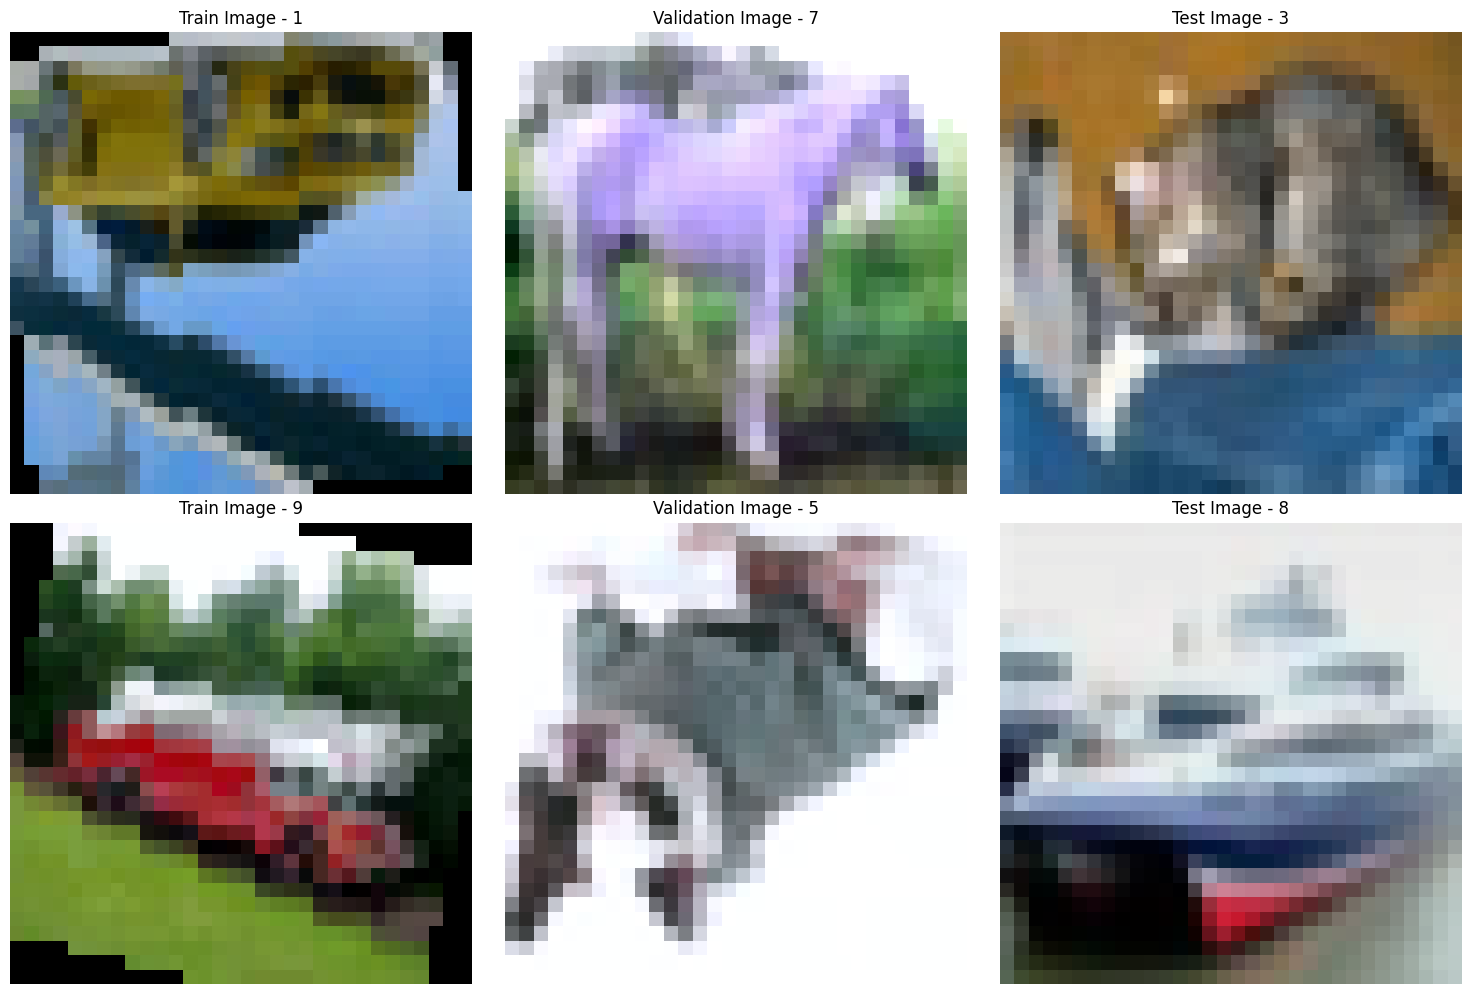

In [13]:
def visualize_data(train_loader, val_loader, test_loader, num_images=2):
    def show_image(image, ax, title):
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.5071, 0.4867, 0.4408])
        std = np.array([0.2675, 0.2565, 0.2761])
        image = std * image + mean  # Unnormalize
        image = np.clip(image, 0, 1)
        ax.imshow(image)
        ax.set_title(title)
        ax.axis('off')
    
    # Get a batch of images from the train, val, and test loaders
    train_iter = iter(train_loader)
    val_iter = iter(val_loader)
    test_iter = iter(test_loader)
    
    # Fetch one batch of images and labels
    train_images, train_labels = next(train_iter)
    val_images, val_labels = next(val_iter)
    test_images, test_labels = next(test_iter)
    
    # Plot images from each dataset
    fig, axarr = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
    for i in range(num_images):
        show_image(train_images[i], axarr[i, 0], f"Train Image - {train_labels[i].item()}")
        show_image(val_images[i], axarr[i, 1], f"Validation Image - {val_labels[i].item()}")
        show_image(test_images[i], axarr[i, 2], f"Test Image - {test_labels[i].item()}")
    
    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_data(train_dataloader, val_dataloader, test_dataloader)

In [ ]:
def training_loop(embedding_strategy, checkpoint_path):
    model = Vit(embedding_strategy, NUM_PATCHES, IMAGE_SIZE, NUM_CLASSES, PATCH_SIZE, EMBEDING_DIMENTION, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)
    
    best_val_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False
    start = timeit.default_timer()
    
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    
    for epoch in tqdm(range(EPOCHS)):
        model.train()
        train_labels, train_preds = [], []
        train_running_loss = 0
        
        for idx, (img, label) in enumerate(tqdm(train_dataloader, position=0, leave=True)):
            img, label = img.to(device), label.to(device)
            img = img.float()  # Ensure img is float
            label = label.type(torch.long)  # Ensure label is long (for CrossEntropyLoss)
            
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            
            train_labels.extend(label.cpu().detach())
            train_preds.extend(y_pred_label.cpu().detach())
            
            loss = criterion(y_pred, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_running_loss += loss.item()
        
        train_loss = train_running_loss / len(train_dataloader)
        
        model.eval()
        val_labels, val_preds = [], []
        val_running_loss = 0
        
        with torch.no_grad():
            for idx, (img, label) in enumerate(tqdm(val_dataloader, position=0, leave=True)):
                img, label = img.to(device), label.to(device)
                img = img.float()  # Ensure img is float
                label = label.type(torch.long)  # Ensure label is long (for CrossEntropyLoss)
                
                y_pred = model(img)
                y_pred_label = torch.argmax(y_pred, dim=1)
                
                val_labels.extend(label.cpu().detach())
                val_preds.extend(y_pred_label.cpu().detach())
                
                loss = criterion(y_pred, label)
                val_running_loss += loss.item()
        
        val_loss = val_running_loss / len(val_dataloader)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Epoch {epoch + 1}: New best model saved with val_loss: {val_loss:.4f}')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve == PATIANCE:
            print("Early stopping triggered")
            early_stop = True
            break
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels))
        val_accuracies.append(sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels))
        
        print("-" * 30)
        print(f"Train Loss EPOCH {epoch + 1}: {train_loss:.4f}")
        print(f"Valid Loss EPOCH {epoch + 1}: {val_loss:.4f}")
        print(f"Train Accuracy EPOCH {epoch + 1}: {train_accuracies[-1]:.4f}")
        print(f"Valid Accuracy EPOCH {epoch + 1}: {val_accuracies[-1]:.4f}")
        print("-" * 30)
    
    if not early_stop:
        print("Completed all epochs without early stopping.")
    
    stop = timeit.default_timer()
    print(f"Training Time: {stop - start:.2f}s")
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    fig.suptitle('Training and Validation Metrics')
    
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Loss over epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(train_accuracies, label='Train Accuracy')
    ax2.plot(val_accuracies, label='Validation Accuracy')
    ax2.set_title('Accuracy over epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.show()
    
    return model

In [ ]:
def test_model(model, checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()
    test_running_loss = 0
    test_labels, test_preds = [], []
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for img, label in tqdm(test_dataloader, position=0, leave=True):
            img, label = img.to(device), label.to(device)
            img = img.float()  # Ensure img is float
            label = label.type(torch.long)  # Ensure label is long (for CrossEntropyLoss)
            
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            
            test_labels.extend(label.cpu().detach())
            test_preds.extend(y_pred_label.cpu().detach())
            
            loss = criterion(y_pred, label)
            test_running_loss += loss.item()
    
    test_loss = test_running_loss / len(test_dataloader)
    test_accuracy = sum(1 for x, y in zip(test_preds, test_labels) if x == y) / len(test_labels)
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
learned_postional_embedding = PatchEmbeddingLearnedPositionalEmbedding(EMBEDING_DIMENTION, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS)
model_learned = training_loop(learned_postional_embedding, 'best_model_learned_embedding.pt')
test_model(model_learned, 'best_model_learned_embedding.pt')

In [ ]:
hilbert_embedding = PatchEmbeddingHilbertPositionalEmbedding(EMBEDING_DIMENTION, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS, IMAGE_SIZE)
model_hilbert = training_loop(hilbert_embedding, 'hilbert_embedding.pt')
test_model(model_hilbert, 'hilbert_embedding.pt')

In [ ]:
no_postional_embedding = PatchEmbeddingNoPositionalEmbedding(EMBEDING_DIMENTION, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS)
model_no_embedding = training_loop(no_postional_embedding, 'best_model_no_embedding.pt')
test_model(model_no_embedding, 'best_model_no_embedding.pt')